<a href="https://colab.research.google.com/github/pouryaShahparast/encrypted-protection/blob/main/enc_protectoin_proto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install phe
!pip install gmpy2

import os
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.8 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import random
import numpy as np
import math
import timeit
import cmath
from scipy.io import loadmat
import matplotlib.pyplot as plt
import phe
from phe import paillier
import gmpy2

In [ ]:
pubkey, privkey = paillier.generate_paillier_keypair(n_length=128)
print(pubkey.n)
print(len(str(pubkey.n)))

209865697250346413302792492522230809573
39


In [ ]:
#basic encryption and dycryption functions
def phe_encrypt(z):
  return pubkey.encrypt(z)

def phe_vec_encrypt(v):
  c = []
  for i in v:
    c.append(phe_encrypt(int(i)))
  return c

def phe_decrypt(c,n):

  return int(gmpy2.f_mod(int(privkey.decrypt(c)), pow(2, n)))
  #int(privkey.decrypt(c)) % pow(2, n)
  #math.fmod(int(privkey.decrypt(c)), pow(2,n))
  #pow(int(privkey.decrypt(c)), 1, pow(2, n))
 #int(privkey.decrypt(c)) % (2**n)

def phe_vec_decrypt(v,n):
  c = []
  for i in v:
    c.append(phe_decrypt(i,n))
  return c

def phe_encrypted_vec_sum(v1,v2):
  c = []
  for i in range(len(v1)):
    c.append(v1[i]+v2[i])
  return c

def phe_encrypted_vec_one_sum(v):
  d = v[0]
  for i in range(1,len(v)):
    d = d + v[i]
  return d

def phe_encrypted_vec_neg(v1,v2):
  c = []
  for i in range(len(v1)):
    c.append(v1[i]-v2[i])
  return c

def phe_encrypted_vec_mul(v,env):
  c = np.zeros_like(env)
  for i in range(len(env)):
    c[i] = v[i] * env[i]
  d = c[0]
  for i in range(1,len(env)):
    d = d + c[i]
  return d

def phe_encrypted_vec_int_mul(k,env):
  c = np.zeros_like(env)
  for i in range(len(env)):
    c[i] = k * env[i]
  return c

def phe_encrypted_mat_vec_mul(mat,env):
  c = np.zeros_like(env)
  for i in range(len(env)):
    c[i] = phe_encrypted_vec_mul(mat[i],env)
  return c

def phe_give_ciphertext_vec(env):
  c = np.zeros_like(env)
  for i in range(len(env)):
    c[i] = env[i].ciphertext()
  return c

def enc_compare_for_dft_protocol(env,n,m,l):
  a = phe_vec_decrypt(env,n+2*m)
  x = complete_vec_inv_map(a,n,m,l)
  z = max(abs(x))
  return phe_encrypt(complete_map(z,n,m))

def enc_compare(c1,c2,n,m,l1,l2):
  z1 = complete_inv_map(phe_decrypt(c1,n+2*m),n,m,l1)
  z2 = complete_inv_map(phe_decrypt(c2,n+2*m),n,m,l2)
  if z1 > z2 :
    s = 1
  else :
    s = 0
  return phe_encrypt(complete_map(s,n,m))

# numsric functions

def quantize(x, m):
  r = 2 ** (-m)
  nearest = round(x / r) * r
  return nearest

def quantize_vec(v, m):
  z = np.zeros_like(v)
  for i, x in enumerate(v):
    z[i] = quantize(x,m)
  return z

def quantize_mat(v, m):
  x = np.zeros_like(v)
  for i in range(np.size(v,0)):
    for j in range(np.size(v,1)):
      x[i,j] = quantize(v[i,j], m)
  return x

def map_range(n,m):
  return [(2 ** (n-m-1)) - (2 ** (-m)), -(2 ** (n-m-1))]

def my_map(x,n,m):
  return int(((2 ** m) * x) % (2 ** n))

def vec_map(v,n,m):
  z = np.zeros_like(v)
  for i, x in enumerate(v):
    z[i] = my_map(x,n,m)
  return z

def mat_map(v,n,m):
  x = np.zeros_like(v)
  for i in range(np.size(v,0)):
    for j in range(np.size(v,1)):
      x[i,j] = my_map(v[i,j],n,m)
  return x

def inv_map(x,n,m):
  return (x - (x >= (2 ** (n-1))) * (2 ** n)) / (2 ** m)

def vec_inv_map(v,n,m):
  z = np.zeros_like(v)
  for i, x in enumerate(v):
    z[i] = inv_map(x,n,m)
  return z

def mat_inv_map(v,n,m):
  x = np.zeros_like(v)
  for i in range(np.size(v,0)):
    for j in range(np.size(v,1)):
      x[i,j] = inv_map(v[i,j],n,m)
  return x

def neg(x,n):
  return ((2 ** n) - x) % (2 ** n)

def summation(x1,x2,n):
  return (x1 + x2) % (2 ** n)

def Subtract(x1,x2,n):
  return (x1 + neg(x2,n)) % (2 ** n)

def multiply(x1,x2,n,m):
  return (((x1 - (x1 >= (2 ** (n-1))) * (2 ** n)) * (x2 - (x2 >= (2 ** (n-1))) * (2 ** n))) / (2 ** m)) % (2 ** n)

def complete_map(x,n,m):
  q = quantize(x,m)
  s = q * ( 2 ** m )
  return my_map(s,n+2*m,0)

def complete_vec_map(v,n,m):
  q = quantize_vec(v,m)
  s = q * ( 2 ** m )
  return vec_map(s,n+2*m,0)

def complete_mat_map(v,n,m):
  q = quantize_mat(v,m)
  s = q * ( 2 ** m )
  return mat_map(s,n+2*m,0)

def complete_inv_map(x,n,m,l):
  return inv_map(x,n+2*m,0) / (2 ** (l*m))

def complete_vec_inv_map(v,n,m,l):
 return vec_inv_map(v,n+2*m,0) / (2 ** (l*m))

def complete_mat_inv_map(v,n,m,l):
 return mat_inv_map(v,n+2*m,0) / (2 ** (l*m))

In [ ]:
n = 17
m = 5
print(f"{map_range(n,m)}")
print(f"{map_range(n+2*m,0)}")

[2047.96875, -2048]
[67108863, -67108864]


In [ ]:
# normal algorithm functions
def amp_match(I1a,I2a,I1b,I2b,I1c,I2c,ct1,ct2,Sb,V1b,V2b):
  k1 = ((ct1) / (Sb/(np.sqrt(3)*V1b)))
  k2 = ((ct2) / (Sb/(np.sqrt(3)*V2b)))

  I1apu = I1a * k1
  I2apu = I2a * k2

  I1bpu = I1b * k1
  I2bpu = I2b * k2

  I1cpu = I1c * k1
  I2cpu = I2c * k2
  return I1apu, I2apu, I1bpu, I2bpu, I1cpu, I2cpu

def vector_matching(I1a,I2a,I1b,I2b,I1c,I2c,n):
  I10 = (I1a + I1b + I1c) / 3
  I20 = (I2a + I2b + I2c) / 3
  pI1a = I1a - I10
  pI1b = I1b - I10
  pI1c = I1c - I10
  match n:
    case 0:
      pI2a = I2a - I20
      pI2b = I2b - I20
      pI2c = I2c - I20
    case 1:
      pI2a = (I2a - I2b) / (np.sqrt(3))
      pI2b = (I2b - I2c) / (np.sqrt(3))
      pI2c = (I2c - I2a) / (np.sqrt(3))
    case _:
      print("n not right")
  return pI1a, pI1b, pI1c, pI2a, pI2b, pI2c

def new_dft(n,f):
  mat = np.zeros((n,n));
  for i in range(n):
    for j in range(n):
      mat[i,j] = np.sqrt(2) * np.cos(((2*np.pi)/n)*f*(i+j)) / n
  return mat

def find_new_dft(n,f,I):
  mat = new_dft(n,f)
  x = mat @ I
  return max(abs(x))

def give_diff_and_bias(I1a,I2a,I1b,I2b,I1c,I2c,n):
  Id1a = find_new_dft(n,1,I1a+I2a)
  Id1b = find_new_dft(n,1,I1b+I2b)
  Id1c = find_new_dft(n,1,I1c+I2c)

  Id2a = find_new_dft(n,2,I1a+I2a)
  Id2b = find_new_dft(n,2,I1b+I2b)
  Id2c = find_new_dft(n,2,I1c+I2c)

  Id5a = find_new_dft(n,5,I1a+I2a)
  Id5b = find_new_dft(n,5,I1b+I2b)
  Id5c = find_new_dft(n,5,I1c+I2c)

  Iba = find_new_dft(n,1,I1a) + find_new_dft(n,1,I2a)
  Ibb = find_new_dft(n,1,I1b) + find_new_dft(n,1,I2b)
  Ibc = find_new_dft(n,1,I1c) + find_new_dft(n,1,I2c)

  return Id1a, Id1b, Id1c, Id2a, Id2b, Id2c, Id5a, Id5b, Id5c, Iba, Ibb, Ibc

def normal_diff_protect(I1a, I1b, I1c, I2a, I2b, I2c, ct1, ct2, Sb, V1b, V2b, vector_group, size_of_vec):
  I1apu, I2apu, I1bpu, I2bpu, I1cpu, I2cpu = amp_match(I1a, I2a, I1b, I2b, I1c, I2c, ct1, ct2, Sb, V1b, V2b)
  pI1a, pI1b, pI1c, pI2a, pI2b, pI2c = vector_matching(I1apu, I2apu, I1bpu, I2bpu, I1cpu, I2cpu,vector_group)
  Id1a, Id1b, Id1c, Id2a, Id2b, Id2c, Id5a, Id5b, Id5c, Iba, Ibb, Ibc = give_diff_and_bias(pI1a,pI2a,pI1b,pI2b,pI1c,pI2c,size_of_vec)
  return Id1a, Id1b, Id1c, Id2a, Id2b, Id2c, Id5a, Id5b, Id5c, Iba, Ibb, Ibc

# encrypted algorithm functions

def en_amp_match(I1a,I2a,I1b,I2b,I1c,I2c,ct1,ct2,Sb,V1b,V2b,n,m):
  xk1 = ((ct1) / (Sb/(np.sqrt(3)*V1b)))
  xk2 = ((ct2) / (Sb/(np.sqrt(3)*V2b)))

  k1 = complete_map(xk1,n,m)
  k2 = complete_map(xk2,n,m)

  I1apu = phe_encrypted_vec_int_mul(k1,I1a)
  I2apu = phe_encrypted_vec_int_mul(k2,I2a)

  I1bpu = phe_encrypted_vec_int_mul(k1,I1b)
  I2bpu = phe_encrypted_vec_int_mul(k2,I2b)

  I1cpu = phe_encrypted_vec_int_mul(k1,I1c)
  I2cpu = phe_encrypted_vec_int_mul(k2,I2c)
  return I1apu, I2apu, I1bpu, I2bpu, I1cpu, I2cpu

def en_vector_matching(I1a,I2a,I1b,I2b,I1c,I2c,num,n,m):
  k1 = complete_map(1/3,n,m)
  k2 = complete_map(1/np.sqrt(3),n,m)

  tI10 = phe_encrypted_vec_sum(phe_encrypted_vec_sum(I1a,I1b),I1c)
  tI20 = phe_encrypted_vec_sum(phe_encrypted_vec_sum(I2a,I2b),I2c)
  I10 = phe_encrypted_vec_int_mul(k1,tI10)
  I20 = phe_encrypted_vec_int_mul(k1,tI20)

  pI1a = phe_encrypted_vec_neg(phe_encrypted_vec_int_mul(complete_map(1,n,m),I1a),I10)
  pI1b = phe_encrypted_vec_neg(phe_encrypted_vec_int_mul(complete_map(1,n,m),I1b),I10)
  pI1c = phe_encrypted_vec_neg(phe_encrypted_vec_int_mul(complete_map(1,n,m),I1c),I10)

  match num:
    case 0:
      pI2a = phe_encrypted_vec_neg(phe_encrypted_vec_int_mul(complete_map(1,n,m),I2a),I20)
      pI2b = phe_encrypted_vec_neg(phe_encrypted_vec_int_mul(complete_map(1,n,m),I2b),I20)
      pI2c = phe_encrypted_vec_neg(phe_encrypted_vec_int_mul(complete_map(1,n,m),I2c),I20)
    case 1:
      pI2a = phe_encrypted_vec_int_mul(k2,phe_encrypted_vec_neg(I2a,I2b))
      pI2b = phe_encrypted_vec_int_mul(k2,phe_encrypted_vec_neg(I2b,I2c))
      pI2c = phe_encrypted_vec_int_mul(k2,phe_encrypted_vec_neg(I2c,I2a))
    case _:
      print("n not right")
  return pI1a, pI1b, pI1c, pI2a, pI2b, pI2c

def en_dft(num,f,I,n,m):
  ma = new_dft(num,f)
  mat = complete_mat_map(ma,n,m)
  x = phe_encrypted_mat_vec_mul(mat,I)
  return x

def en_diff_and_bias_vecs(I1a,I2a,I1b,I2b,I1c,I2c,num,n,m):
  Id1a = en_dft(num,1,phe_encrypted_vec_sum(I1a,I2a),n,m)
  Id1b = en_dft(num,1,phe_encrypted_vec_sum(I1b,I2b),n,m)
  Id1c = en_dft(num,1,phe_encrypted_vec_sum(I1c,I2c),n,m)

  Id2a = en_dft(num,2,phe_encrypted_vec_sum(I1a,I2a),n,m)
  Id2b = en_dft(num,2,phe_encrypted_vec_sum(I1b,I2b),n,m)
  Id2c = en_dft(num,2,phe_encrypted_vec_sum(I1c,I2c),n,m)

  Id5a = en_dft(num,5,phe_encrypted_vec_sum(I1a,I2a),n,m)
  Id5b = en_dft(num,5,phe_encrypted_vec_sum(I1b,I2b),n,m)
  Id5c = en_dft(num,5,phe_encrypted_vec_sum(I1c,I2c),n,m)

  Iba1 = en_dft(num,1,I1a,n,m)
  Iba2 = en_dft(num,1,I2a,n,m)

  Ibb1 = en_dft(num,1,I1b,n,m)
  Ibb2 = en_dft(num,1,I2b,n,m)

  Ibc1 = en_dft(num,1,I1c,n,m)
  Ibc2 = en_dft(num,1,I2c,n,m)

  return Id1a, Id1b, Id1c, Id2a, Id2b, Id2c, Id5a, Id5b, Id5c, Iba1, Ibb1, Ibc1, Iba2, Ibb2, Ibc2

def en_diff_bias(I1a,I2a,I1b,I2b,I1c,I2c,num,n,m):
  eId1a, eId1b, eId1c, eId2a, eId2b, eId2c, eId5a, eId5b, eId5c, eIba1, eIbb1, eIbc1, eIba2, eIbb2, eIbc2 = en_diff_and_bias_vecs(I1a,I2a,I1b,I2b,I1c,I2c,num,n,m)

  Id1a = enc_compare_for_dft_protocol(eId1a,n,m,4)
  Id1b = enc_compare_for_dft_protocol(eId1b,n,m,4)
  Id1c = enc_compare_for_dft_protocol(eId1c,n,m,4)

  Id2a = enc_compare_for_dft_protocol(eId2a,n,m,4)
  Id2b = enc_compare_for_dft_protocol(eId2b,n,m,4)
  Id2c = enc_compare_for_dft_protocol(eId2c,n,m,4)

  Id5a = enc_compare_for_dft_protocol(eId5a,n,m,4)
  Id5b = enc_compare_for_dft_protocol(eId5b,n,m,4)
  Id5c = enc_compare_for_dft_protocol(eId5c,n,m,4)

  IaL = enc_compare_for_dft_protocol(eIba1,n,m,4)

  Iba = IaL + enc_compare_for_dft_protocol(eIba2,n,m,4)
  Ibb = enc_compare_for_dft_protocol(eIbb1,n,m,4) + enc_compare_for_dft_protocol(eIbb2,n,m,4)
  Ibc = enc_compare_for_dft_protocol(eIbc1,n,m,4) + enc_compare_for_dft_protocol(eIbc2,n,m,4)

  return Id1a, Id1b, Id1c, Id2a, Id2b, Id2c, Id5a, Id5b, Id5c, Iba, Ibb, Ibc, IaL

def enc_diff_protect(eI1a, eI1b, eI1c, eI2a, eI2b, eI2c, ct1, ct2, Sb, V1b, V2b, vector_group, size_of_vec, n, m):
  eI1apu, eI2apu, eI1bpu, eI2bpu, eI1cpu, eI2cpu = en_amp_match(eI1a, eI2a, eI1b, eI2b, eI1c, eI2c, ct1, ct2, Sb, V1b, V2b, n, m)
  epI1a, epI1b, epI1c, epI2a, epI2b, epI2c = en_vector_matching(eI1apu, eI2apu, eI1bpu, eI2bpu, eI1cpu, eI2cpu,vector_group,n,m)
  eId1a, eId1b, eId1c, eId2a, eId2b, eId2c, eId5a, eId5b, eId5c, eIba, eIbb, eIbc, eIaL= en_diff_bias(epI1a,epI2a,epI1b,epI2b,epI1c,epI2c,size_of_vec,n,m)
  return eId1a, eId1b, eId1c, eId2a, eId2b, eId2c, eId5a, eId5b, eId5c, eIba, eIbb, eIbc, epI1a, eIaL

def enc_compare_line_foult(Id,Ib,k,b,n,m):
  x = (k * Ib) + (complete_map(1,n,m) * b)
  return enc_compare(Id,x,n,m,1,2)

def enc_compare_line_CT(Id,Ib,k,b,n,m):
  x = (k * Ib) + (complete_map(1,n,m) * b)
  return enc_compare(x,Id,n,m,2,1)

def enc_foult(Id,Ib,k1,k2,b0,b1,b2,n,m):
  s1 = enc_compare(Id,b0,n,m,1,1)
  s2 = enc_compare_line_foult(Id,Ib,k1,b1,n,m)
  s3 = enc_compare_line_foult(Id,Ib,k2,b2,n,m)
  return enc_compare(s1+s2+s3,phe_encrypt(complete_map(2,n,m)),n,m,1,1)

def enc_harmonic_check(Id,Id25,k,n,m):
  return enc_compare(Id25, k * Id, n,m,1,2)

def enc_CT_sat(Id,Ib,k,b0,b1,n,m):
  s1 = enc_compare(Ib,b0,n,m,1,1)
  s2 = enc_compare_line_CT(Id,Ib,k,b1,n,m)
  return enc_compare(s1+s2,phe_encrypt(complete_map(1,n,m)),n,m,1,1)

def give_block(m2,m5,mCT,n,m):
  s2 = phe_encrypted_vec_one_sum(m2)
  s5 = phe_encrypted_vec_one_sum(m5)
  sCT = phe_encrypted_vec_one_sum(mCT)
  return enc_compare(phe_encrypt(complete_map(1,n,m)),s2+s5+sCT,n,m,1,1)

def give_trip(sf,sb,n,m):
  return enc_compare(sf+sb,phe_encrypt(complete_map(1,n,m)),n,m,1,1)


In [ ]:
def give_currents(foult,vector_group,frequency,start_time,stop_time):
  # foult = 'in' or 'ex'
  # frequency = '47.5' '50_3' '50_4'
  strHV = '/content/drive/MyDrive/current_data/I_HV_' + foult + '_' + str(vector_group) + '_' + frequency + '.mat'
  strLV = '/content/drive/MyDrive/current_data/I_LV_' + foult + '_' + str(vector_group) + '_' + frequency + '.mat'
  data1 = loadmat(strHV)
  data2 = loadmat(strLV)
  I1 = data1['I_HV_phase_com']
  I2 = data2['I_LV_phase_com']
  l = len(I1[:,0])
  I1a = I1[int((start_time/2.4)*l):int((stop_time/2.4)*l),0]
  I1b = I1[int((start_time/2.4)*l):int((stop_time/2.4)*l),1]
  I1c = I1[int((start_time/2.4)*l):int((stop_time/2.4)*l),2]

  I2a = I2[int((start_time/2.4)*l):int((stop_time/2.4)*l),0]
  I2b = I2[int((start_time/2.4)*l):int((stop_time/2.4)*l),1]
  I2c = I2[int((start_time/2.4)*l):int((stop_time/2.4)*l),2]

  I1a = I1a[::4]
  I1b = I1b[::4]
  I1c = I1c[::4]

  I2a = I2a[::4]
  I2b = I2b[::4]
  I2c = I2c[::4]

  return I1a, I1b, I1c, I2a, I2b, I2c

def give_window(I1a, I1b, I1c, I2a, I2b, I2c, i, size_of_vec):
  I1a_w = I1a[i:i+size_of_vec]
  I1b_w = I1b[i:i+size_of_vec]
  I1c_w = I1c[i:i+size_of_vec]

  I2a_w = I2a[i:i+size_of_vec]
  I2b_w = I2b[i:i+size_of_vec]
  I2c_w = I2c[i:i+size_of_vec]
  return I1a_w, I1b_w, I1c_w, I2a_w, I2b_w, I2c_w

def current_plot(I,eI,start_time,end_time,name):
  time = np.arange(start_time - start_time, end_time - start_time, 0.001)

  plt.figure(figsize=(10, 6))
  plt.plot(time, I, color='blue', label='I')
  plt.scatter(time, phe_give_ciphertext_vec(eI) / 10e75, color='red', label='normalized encrypted I')
  #plt.plot(time, phe_give_ciphertext_vec(eI) / 10e75, color='red', label='normalized encrypted I')

  plt.xlabel('Time')
  plt.ylabel('Current')
  plt.title(name)
  plt.legend()
  plt.savefig(name+'.png', dpi=300, bbox_inches='tight')
  plt.show()



def dycript_currs(eId1a, eId1b, eId1c, eId2a, eId2b, eId2c, eId5a, eId5b, eId5c, eIba, eIbb, eIbc, i):
  dId1a = complete_inv_map(phe_decrypt(eId1a,n+2*m),n,m,1)
  dId1b = complete_inv_map(phe_decrypt(eId1b,n+2*m),n,m,1)
  dId1c = complete_inv_map(phe_decrypt(eId1c,n+2*m),n,m,1)

  dId2a = complete_inv_map(phe_decrypt(eId2a,n+2*m),n,m,1)
  dId2b = complete_inv_map(phe_decrypt(eId2b,n+2*m),n,m,1)
  dId2c = complete_inv_map(phe_decrypt(eId2c,n+2*m),n,m,1)

  dId5a = complete_inv_map(phe_decrypt(eId5a,n+2*m),n,m,1)
  dId5b = complete_inv_map(phe_decrypt(eId5b,n+2*m),n,m,1)
  dId5c = complete_inv_map(phe_decrypt(eId5c,n+2*m),n,m,1)

  dIba = complete_inv_map(phe_decrypt(eIba,n+2*m),n,m,1)
  dIbb = complete_inv_map(phe_decrypt(eIbb,n+2*m),n,m,1)
  dIbc = complete_inv_map(phe_decrypt(eIbc,n+2*m),n,m,1)

  return dId1a, dId1b, dId1c, dId2a, dId2b, dId2c, dId5a, dId5b, dId5c, dIba, dIbb, dIbc

def create_all_Is(s):
  return np.zeros(s),np.zeros(s),np.zeros(s) , np.zeros(s),np.zeros(s),np.zeros(s) , np.zeros(s),np.zeros(s),np.zeros(s) , np.zeros(s),np.zeros(s),np.zeros(s)

def create_memmory(s,n,m):
  return phe_vec_encrypt(complete_vec_map(np.zeros(s),n,m)),phe_vec_encrypt(complete_vec_map(np.zeros(s),n,m)),phe_vec_encrypt(complete_vec_map(np.zeros(s),n,m))


def modify(arr, x):
  arr.pop()
  arr.insert(0, x)

def update_memmory(m2a,m2b,m2c,m5a,m5b,m5c,mCTa,mCTb,mCTc,a2,b2,c2,a5,b5,c5,aCT,bCT,cCT):
  modify(m2a, a2)
  modify(m2b, b2)
  modify(m2c, c2)

  modify(m5a, a5)
  modify(m5b, b5)
  modify(m5c, c5)

  modify(mCTa, aCT)
  modify(mCTb, bCT)
  modify(mCTc, cCT)

def update_alls(all_Id1a, all_Id1b, all_Id1c, all_Id2a, all_Id2b, all_Id2c, all_Id5a, all_Id5b, all_Id5c, all_Iba, all_Ibb, all_Ibc,Id1a, Id1b, Id1c, Id2a, Id2b, Id2c, Id5a, Id5b, Id5c, Iba, Ibb, Ibc,i):
  all_Id1a[i] = Id1a
  all_Id1b[i] = Id1b
  all_Id1c[i] = Id1c

  all_Id2a[i] = Id2a
  all_Id2b[i] = Id2b
  all_Id2c[i] = Id2c

  all_Id5a[i] = Id5a
  all_Id5b[i] = Id5b
  all_Id5c[i] = Id5c

  all_Iba[i] = Iba
  all_Ibb[i] = Ibb
  all_Ibc[i] = Ibc

def update_mf(mfa, mfb, mfc, fa, fb, fc, i):
  mfa[i] = fa
  mfb[i] = fb
  mfc[i] = fc

def one_inrush(alpha,k,f):
  t = np.arange(0, 1/f, 0.001)
  inrush = np.zeros(len(t))
  w = 2 * np.pi * f
  a = k / (1- np.cos(alpha))

  t1 = (1/(2*f)) - (alpha / w)
  t2 = (1/(2*f)) + (alpha / w)

  for i in range(len(t)):
    if (t[i] >= t1) and (t[i] <= t2):
      inrush[i] = a * (np.cos(w * t[i] - np.pi) - np.cos(alpha))
  return inrush

def generate_inrush_current(alpha,k,f,cycles):
  inrush = np.zeros(len(np.arange(0, cycles/f, 0.001)))
  a = len(np.arange(0, 1/f, 0.001))
  for i in range(cycles):
    inrush[i*a:(i+1)*a] = one_inrush(alpha,k,f)
  return inrush

def generate_inrush_ynyn(alpha,k,f,cycles):

  I1a = generate_inrush_current(alpha,k,f,cycles)
  I1b = np.zeros(len(np.arange(0, cycles/f, 0.001)))
  I1c = np.zeros(len(np.arange(0, cycles/f, 0.001)))

  I2a = np.zeros(len(np.arange(0, cycles/f, 0.001)))
  I2b = np.zeros(len(np.arange(0, cycles/f, 0.001)))
  I2c = np.zeros(len(np.arange(0, cycles/f, 0.001)))

  return I1a, I1b, I1c, I2a, I2b, I2c

def one_overexcitation(alpha,k,f):
  t = np.arange(0, 1/f, 0.001)
  overex = np.zeros(len(t))
  w = 2 * np.pi * f
  a = k / (1- np.cos(alpha))

  t0 = 0
  t1 = alpha / w
  t2 = (1/f) - t1
  t3 = 1/f
  t4 = (1/(2*f)) - t1
  t5 = (1/(2*f)) + t1

  for i in range(len(t)):
    if ((t[i] >= t0) and (t[i] <= t1)) or ((t[i] >= t2) and (t[i] <= t3)):
      overex[i] = a * (np.cos(w * t[i]) - np.cos(alpha))
    elif (t[i] >= t4) and (t[i] <= t5):
      overex[i] = a * (np.cos(w * t[i]) + np.cos(alpha))

  return overex

def generate_overexcitation_current(alpha,k,f,cycles):
  overex = np.zeros(len(np.arange(0, cycles/f, 0.001)))
  a = len(np.arange(0, 1/f, 0.001))
  for i in range(cycles):
    overex[i*a:(i+1)*a] = one_overexcitation(alpha,k,f)
  return overex

def generate_overexcitation_ynyn(alpha,k,f,cycles):
  l = len(np.arange(0, 1/f, 0.001))
  I = generate_overexcitation_current(alpha,k,f,cycles+1)
  I1a = I[0:cycles*l]
  I1b = I[int((2/3)*l):cycles*l + int((2/3)*l)]
  I1c = I[int((1/3)*l):cycles*l + int((1/3)*l)]

  I2a = np.zeros(len(np.arange(0, cycles/f, 0.001)))
  I2b = np.zeros(len(np.arange(0, cycles/f, 0.001)))
  I2c = np.zeros(len(np.arange(0, cycles/f, 0.001)))
  return I1a, I1b, I1c, I2a, I2b, I2c


In [ ]:
b0_foult = phe_encrypt(complete_map(0.25,n,m))
b1_foult = phe_encrypt(complete_map(-0.05,n,m))
b2_foult = phe_encrypt(complete_map(-1.25,n,m))

k1_foult = complete_map(0.25,n,m)
k2_foult = complete_map(0.5,n,m)

b0_CT = phe_encrypt(complete_map(4,n,m))
b1_CT = phe_encrypt(complete_map(-0.05,n,m))

k_CT = complete_map(0.25,n,m)

k2 = complete_map(0.15,n,m)
k5 = complete_map(0.3,n,m)

n2 = 1
n5 = 1
nCT = 100

vg = 1

start_time = 1.35
end_time = 1.45

# inrush
alpha_in = (np.pi / 180) * 120
k_in = 4
f = 50
cycles_in = 4

# ex

f = 50
cycles_ex = 4
k_ex = 2.0082
alpha_ex = (np.pi / 180) * 22.5

In [ ]:
I1a, I1b, I1c, I2a, I2b, I2c = give_currents('in',vg,'50_7a',start_time,end_time)
#I1a, I1b, I1c, I2a, I2b, I2c = generate_inrush_ynyn(alpha_in,k_in,f,cycles_in)
#I1a, I1b, I1c, I2a, I2b, I2c = generate_overexcitation_ynyn(alpha_ex,k_ex,f,cycles_ex)
eI1a = phe_vec_encrypt(complete_vec_map(I1a,n,m))
eI2a = phe_vec_encrypt(complete_vec_map(I2a,n,m))
eI1b = phe_vec_encrypt(complete_vec_map(I1b,n,m))
eI2b = phe_vec_encrypt(complete_vec_map(I2b,n,m))
eI1c = phe_vec_encrypt(complete_vec_map(I1c,n,m))
eI2c = phe_vec_encrypt(complete_vec_map(I2c,n,m))

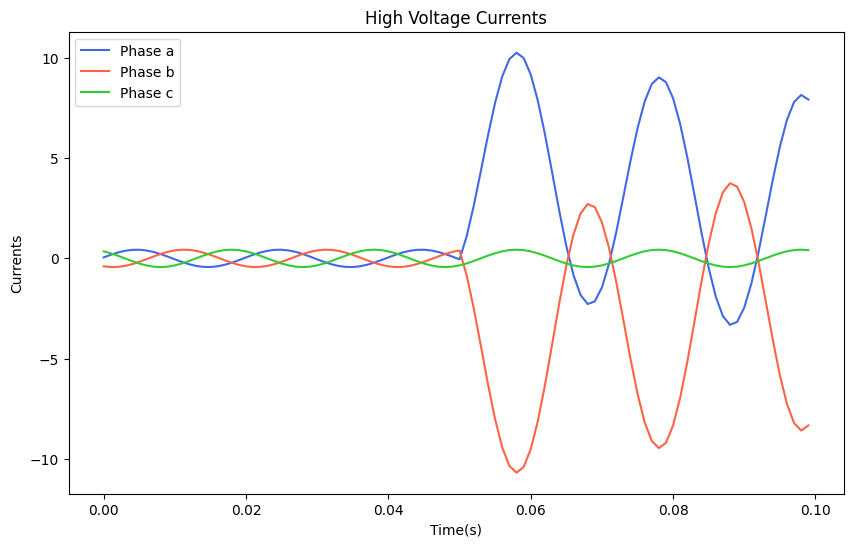

In [ ]:
#current_plot(I1a,eI1a,start_time,end_time,'CT saturation')
#current_plot(I2a,eI2a,start_time,end_time,'phase a2')
#current_plot(I1b,eI1b,start_time,end_time,'phase b')
#current_plot(I2b,eI2b,start_time,end_time,'phase b2')
#current_plot(I1c,eI1c,start_time,end_time,'phase c')
#current_plot(I2c,eI2c,start_time,end_time,'phase c2')

time1 = np.arange(start_time - start_time, end_time - start_time, 0.001)
#print(len(time))
#print(len(I1a))

plt.figure(figsize=(10, 6))
plt.plot(time1, I2a, color = 'royalblue', label='Phase a')
plt.plot(time1, I2b, color = 'tomato', label='Phase b')
plt.plot(time1, I2c, color = 'limegreen', label='Phase c')

plt.xlabel('Time(s)')
plt.ylabel('Currents')
plt.title('High Voltage Currents')
plt.legend()
plt.savefig('Internal fault high.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
t = np.arange(0, cycles_ex/f, 0.001)
plt.figure(figsize=(10, 6))
plt.plot(t, I1a, color='blue', label='I')
plt.plot(t, phe_give_ciphertext_vec(eI1a) / 10e75, color='red', label='normalized encrypted I')
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('phase a1')
plt.legend()
plt.savefig('Inrush current.png', dpi=300, bbox_inches='tight')
plt.show()

#plt.figure(figsize=(10, 6))
#plt.plot(t, I2b, color='blue', label='I')
#plt.scatter(t, phe_give_ciphertext_vec(eI2a) / 10e75, color='red', label='normalized encrypted I')
#plt.xlabel('Time')
#plt.ylabel('Value')
#plt.title('phase a2')
#plt.legend()
#plt.show()

In [ ]:
size_of_vec = 20

s = len(I1a) - (size_of_vec - 1)
mfa, mfb, mfc = create_memmory(s,n,m)
mta, mtb, mtc = create_memmory(s,n,m)

msba, msbb, msbc = create_memmory(s,n,m)

all_mm2a, all_mm5a, all_mmCTa = create_memmory(s,n,m)

all_m2a, all_m2b, all_m2c = create_memmory(s,n,m)
all_m5a, all_m5b, all_m5c = create_memmory(s,n,m)
all_mCTa, all_mCTb, all_mCTc = create_memmory(s,n,m)

m2a, m2b, m2c = create_memmory(n2,n,m)
m5a, m5b, m5c = create_memmory(n5,n,m)
mCTa, mCTb, mCTc = create_memmory(nCT,n,m)

all_Id1a, all_Id1b, all_Id1c, all_Id2a, all_Id2b, all_Id2c, all_Id5a, all_Id5b, all_Id5c, all_Iba, all_Ibb, all_Ibc = create_all_Is(s)
all_dId1a, all_dId1b, all_dId1c, all_dId2a, all_dId2b, all_dId2c, all_dId5a, all_dId5b, all_dId5c, all_dIba, all_dIbb, all_dIbc = create_all_Is(s)

##

mLaL, mDaL, mDaD = create_memmory(s,n,m)
mDaR, m1qqq, m2qqq = create_memmory(s,n,m)

print(s)
for i in range(s):
  I1a_w, I1b_w, I1c_w, I2a_w, I2b_w, I2c_w = give_window(I1a, I1b, I1c, I2a, I2b, I2c, i, size_of_vec)
  eI1a_w, eI1b_w, eI1c_w, eI2a_w, eI2b_w, eI2c_w = give_window(eI1a, eI1b, eI1c, eI2a, eI2b, eI2c, i, size_of_vec)

  Id1a, Id1b, Id1c, Id2a, Id2b, Id2c, Id5a, Id5b, Id5c, Iba, Ibb, Ibc = normal_diff_protect(I1a_w, I1b_w, I1c_w, I2a_w, I2b_w, I2c_w, 500,1000,200e6,230e3,115e3, vg, size_of_vec)
  eId1a, eId1b, eId1c, eId2a, eId2b, eId2c, eId5a, eId5b, eId5c, eIba, eIbb, eIbc, epI1a, eIaL = enc_diff_protect(eI1a_w, eI1b_w, eI1c_w, eI2a_w, eI2b_w, eI2c_w, 500,1000,200e6,230e3,115e3, vg, size_of_vec, n, m)




  fa = enc_foult(eId1a,eIba,k1_foult,k2_foult,b0_foult,b1_foult,b2_foult,n,m)
  fb = enc_foult(eId1b,eIbb,k1_foult,k2_foult,b0_foult,b1_foult,b2_foult,n,m)
  fc = enc_foult(eId1c,eIbc,k1_foult,k2_foult,b0_foult,b1_foult,b2_foult,n,m)

  a2 = enc_harmonic_check(eId1a,eId2a,k2,n,m)
  b2 = enc_harmonic_check(eId1b,eId2b,k2,n,m)
  c2 = enc_harmonic_check(eId1c,eId2c,k2,n,m)

  a5 = enc_harmonic_check(eId1a,eId5a,k5,n,m)
  b5 = enc_harmonic_check(eId1b,eId5b,k5,n,m)
  c5 = enc_harmonic_check(eId1c,eId5c,k5,n,m)

  aCT = enc_CT_sat(eId1a,eIba,k_CT,b0_CT,b1_CT,n,m)
  bCT = enc_CT_sat(eId1b,eIbb,k_CT,b0_CT,b1_CT,n,m)
  cCT = enc_CT_sat(eId1c,eIbc,k_CT,b0_CT,b1_CT,n,m)

  update_memmory(m2a,m2b,m2c,m5a,m5b,m5c,mCTa,mCTb,mCTc,a2,b2,c2,a5,b5,c5,aCT,bCT,cCT)


  xa2 = phe_encrypted_vec_one_sum(m2a)
  xa5 = phe_encrypted_vec_one_sum(m5a)
  xaCT = phe_encrypted_vec_one_sum(mCTa)

  ssa2 = enc_compare(phe_encrypt(complete_map(1,n,m)),xa2,n,m,1,1)
  ssa5 = enc_compare(phe_encrypt(complete_map(1,n,m)),xa5,n,m,1,1)
  ssaCT = enc_compare(phe_encrypt(complete_map(1,n,m)),xaCT,n,m,1,1)

  update_mf(all_mm2a, all_mm5a, all_mmCTa, ssa2, ssa5, ssaCT, i)


  sba = give_block(m2a,m5a,mCTa,n,m)
  sbb = give_block(m2b,m5b,mCTb,n,m)
  sbc = give_block(m2c,m5c,mCTc,n,m)

  ta = give_trip(fa,sba,n,m)
  tb = give_trip(fb,sbb,n,m)
  tc = give_trip(fc,sbc,n,m)

  dId1a, dId1b, dId1c, dId2a, dId2b, dId2c, dId5a, dId5b, dId5c, dIba, dIbb, dIbc = dycript_currs(eId1a, eId1b, eId1c, eId2a, eId2b, eId2c, eId5a, eId5b, eId5c, eIba, eIbb, eIbc, i)

  update_alls(all_Id1a, all_Id1b, all_Id1c, all_Id2a, all_Id2b, all_Id2c, all_Id5a, all_Id5b, all_Id5c, all_Iba, all_Ibb, all_Ibc,Id1a, Id1b, Id1c, Id2a, Id2b, Id2c, Id5a, Id5b, Id5c, Iba, Ibb, Ibc,i)
  update_alls(all_dId1a, all_dId1b, all_dId1c, all_dId2a, all_dId2b, all_dId2c, all_dId5a, all_dId5b, all_dId5c, all_dIba, all_dIbb, all_dIbc,dId1a, dId1b, dId1c, dId2a, dId2b, dId2c, dId5a, dId5b, dId5c, dIba, dIbb, dIbc,i)


  update_mf(mfa, mfb, mfc, fa, fb, fc, i)
  update_mf(mta, mtb, mtc, ta, tb, tc, i)

  update_mf(all_m2a, all_m2b, all_m2c, a2, b2, c2, i)
  update_mf(all_m5a, all_m5b, all_m5c, a5, b5, c5, i)
  update_mf(all_mCTa, all_mCTb, all_mCTc, aCT, bCT, cCT, i)

  update_mf(msba, msbb, msbc, sba, sbb, sbc, i)

  update_mf(mLaL, mDaL, mDaD, epI1a, eIaL, eId1a, i)
  update_mf(mDaR, m1qqq, m2qqq, eIba, eIba, eIba, i)


81


In [ ]:
def flip_array(arr):
  return [1 - x for x in arr]

In [ ]:
print('Idiff')
print(all_Id1a)
print(all_dId1a)
print("---------")
print('Ibias')
print(all_dIba)
print("---------")
print('2 harmonic')
print(all_dId2a)
print("---------")
print('5 harmonic')
print(all_dId5a)

print('-----------------------------------')
print('foult:')
print(complete_vec_inv_map(phe_vec_decrypt(mfa,n+2*m),n,m,1))
#print(complete_vec_inv_map(phe_vec_decrypt(mfb,n+2*m),n,m,1))
#print(complete_vec_inv_map(phe_vec_decrypt(mfc,n+2*m),n,m,1))
print("-----------------------------")
print('2 harmonic:')
print(complete_vec_inv_map(phe_vec_decrypt(all_m2a,n+2*m),n,m,1))
print('2 harmonic:')
print(complete_vec_inv_map(phe_vec_decrypt(all_mm2a,n+2*m),n,m,1))
print('5 harmonic:')
print(complete_vec_inv_map(phe_vec_decrypt(all_m5a,n+2*m),n,m,1))
print('5 harmonic:')
print(complete_vec_inv_map(phe_vec_decrypt(all_mm5a,n+2*m),n,m,1))
print('CT:')
print(complete_vec_inv_map(phe_vec_decrypt(all_mmCTa,n+2*m),n,m,1))
print('CT:')
print(flip_array(complete_vec_inv_map(phe_vec_decrypt(all_mmCTa,n+2*m),n,m,1)))
print("-----------------------------")
print('block: (1 means no block)')
print(complete_vec_inv_map(phe_vec_decrypt(msba,n+2*m),n,m,1))
print('trip:')
print(complete_vec_inv_map(phe_vec_decrypt(mta,n+2*m),n,m,1))

Idiff
[2.63753322e-04 2.63753322e-04 2.63753322e-04 2.63753322e-04
 2.63753322e-04 2.63753322e-04 2.63753322e-04 2.63753322e-04
 2.63753322e-04 2.63753322e-04 2.63753322e-04 2.63753322e-04
 2.63753322e-04 2.63753322e-04 2.63753322e-04 2.63753322e-04
 2.63753322e-04 2.63753322e-04 2.63753322e-04 2.63753322e-04
 2.63753322e-04 2.63753322e-04 2.63753322e-04 2.63753322e-04
 2.63753322e-04 2.63753322e-04 2.63753322e-04 2.63753322e-04
 2.63753322e-04 2.63753322e-04 2.63753322e-04 2.63753322e-04
 2.09636624e-01 6.75093420e-01 1.40874641e+00 2.40774097e+00
 3.57380899e+00 4.81724228e+00 6.12144914e+00 7.22215486e+00
 8.18304299e+00 8.80974455e+00 9.19453226e+00 9.19453226e+00
 9.14399791e+00 9.04602050e+00 9.02843286e+00 9.18937201e+00
 9.52044604e+00 9.92445924e+00 1.02688795e+01 1.04529875e+01
 1.05845576e+01 1.06525819e+01 1.06525819e+01 1.05867933e+01
 1.04637297e+01 1.02971539e+01 1.01045772e+01 9.90544552e+00
 9.71919826e+00 9.56339221e+00 9.45206829e+00 9.39451167e+00
 9.39451167e+00 9.

In [ ]:
print(len(mLaL))
ealv = []
for i in range(20):
  ealv.append(mLaL[0][i])
print(i)
for i in range(20,len(eI1a) - 19):
  ealv.append(mLaL[i][19])

print(ealv[1].ciphertext())

81
19
7385738745066368139510776137467644667410919000891168585505680963767588392301


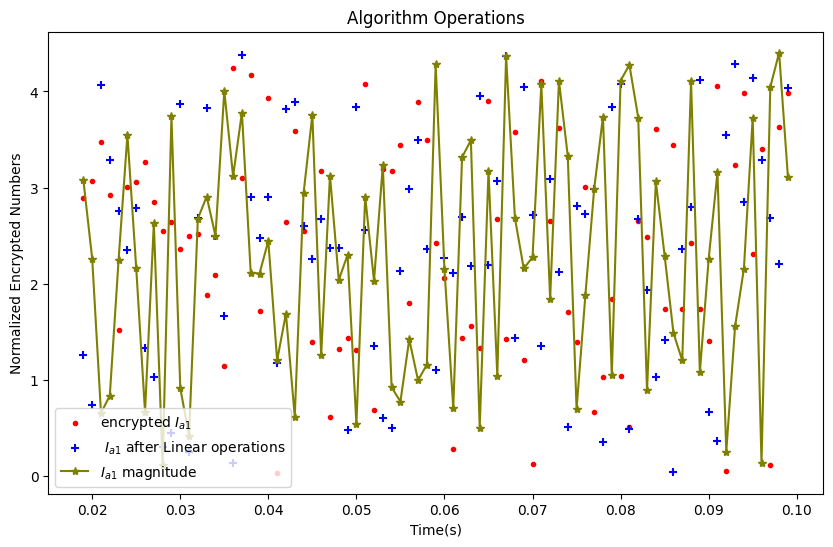

In [ ]:
plt.figure(figsize=(10, 6))
time1 = np.arange(start_time - start_time, end_time - start_time, 0.001)
time = np.arange(0.019, end_time - start_time, 0.001)
plt.scatter(time, phe_give_ciphertext_vec(eI1a[19:]) / 10e75, color='red', label='encrypted $I_{a1}$', marker = ".")

plt.scatter(time, phe_give_ciphertext_vec(ealv) / 10e75, color='blue', label=' $I_{a1}$ after Linear operations', marker = "+")
plt.plot(time, phe_give_ciphertext_vec(mDaL) / 10e75, color='olive', label='$I_{a1}$ magnitude', marker = "*")

#plt.plot(time, complete_vec_inv_map(phe_vec_decrypt(mDaL,n+2*m),n,m,1))

#plt.plot(time, complete_vec_inv_map(phe_vec_decrypt(ealv,n+2*m),n,m,3), color='blue', label='I')
#plt.scatter(time, phe_give_ciphertext_vec(eI1a) / 10e75, color='red', label='Low Voltage Phase a', marker = ".")
#plt.scatter(time, phe_give_ciphertext_vec(eI1a) / 10e75, color='red', label='Low Voltage Phase a', marker = ".")
plt.xlabel('Time(s)')
plt.ylabel('Normalized Encrypted Numbers')
plt.title('Algorithm Operations')
plt.legend()
plt.savefig('low phase a op.png', dpi=300, bbox_inches='tight')
plt.show()

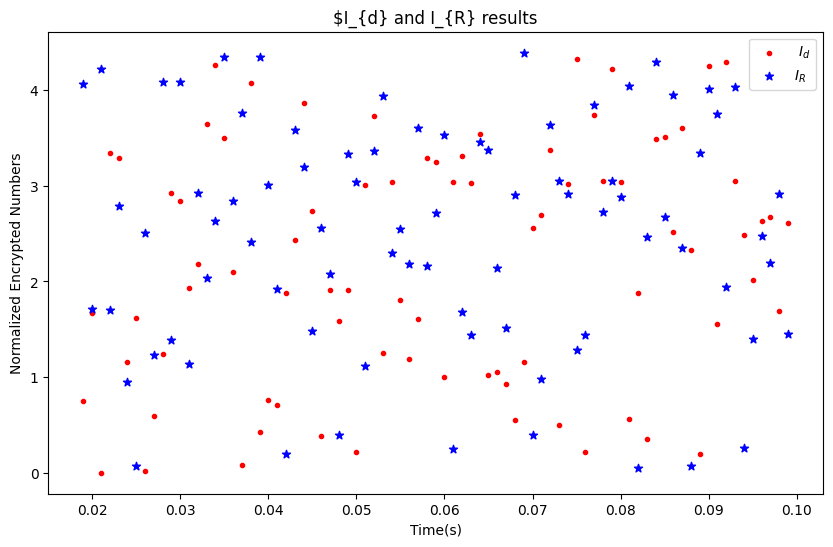

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(time, phe_give_ciphertext_vec(mDaD) / 10e75, color='red', label=' $I_{d}$', marker = ".")
#plt.plot(time, complete_vec_inv_map(phe_vec_decrypt(mDaD,n+2*m),n,m,1))
plt.scatter(time, phe_give_ciphertext_vec(mDaR) / 10e75, color='blue', label='$I_{R}$', marker = "*")

#plt.plot(time, complete_vec_inv_map(phe_vec_decrypt(ealv,n+2*m),n,m,3), color='blue', label='I')
#plt.scatter(time, phe_give_ciphertext_vec(eI1a) / 10e75, color='red', label='Low Voltage Phase a', marker = ".")
#plt.scatter(time, phe_give_ciphertext_vec(eI1a) / 10e75, color='red', label='Low Voltage Phase a', marker = ".")
plt.xlabel('Time(s)')
plt.ylabel('Normalized Encrypted Numbers')
plt.title('$I_{d} and I_{R} results')
plt.legend()
plt.savefig('diff.png', dpi=300, bbox_inches='tight')
plt.show()

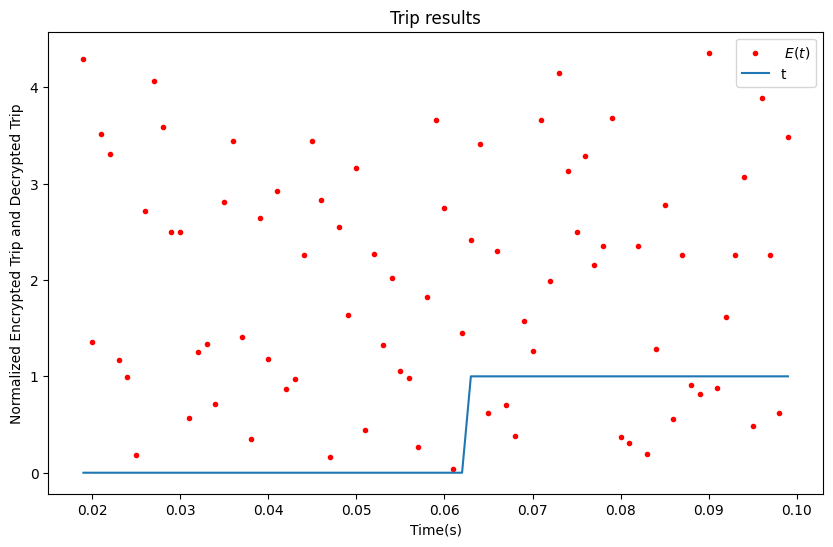

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(time, phe_give_ciphertext_vec(mta) / 10e75, color='red', label=' $E(t)$', marker = ".")
plt.plot(time, complete_vec_inv_map(phe_vec_decrypt(mta,n+2*m),n,m,1), label = 't')
#plt.scatter(time, phe_give_ciphertext_vec(mDaR) / 10e75, color='blue', label='$I_{R}$', marker = "*")

#plt.plot(time, complete_vec_inv_map(phe_vec_decrypt(ealv,n+2*m),n,m,3), color='blue', label='I')
#plt.scatter(time, phe_give_ciphertext_vec(eI1a) / 10e75, color='red', label='Low Voltage Phase a', marker = ".")
#plt.scatter(time, phe_give_ciphertext_vec(eI1a) / 10e75, color='red', label='Low Voltage Phase a', marker = ".")
plt.xlabel('Time(s)')
plt.ylabel('Normalized Encrypted Trip and Decrypted Trip')
plt.title('Trip results')
plt.legend()
plt.savefig('trip.png', dpi=300, bbox_inches='tight')
plt.show()

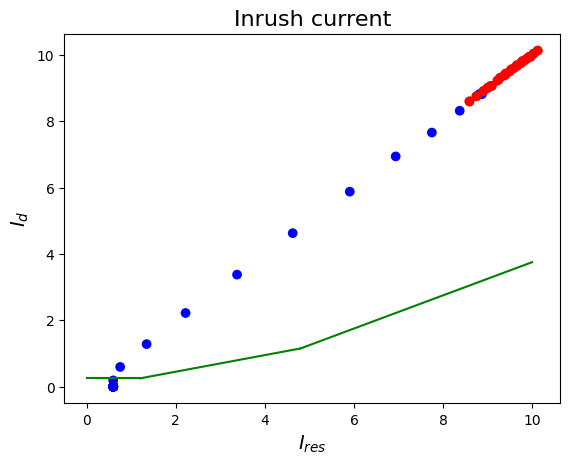

In [ ]:
def lines(k1,k2,b0,b1,b2,a1,a2,a3):
  line1_x = np.array([0, a1])
  line1_y = np.array([b0, b0])

  line2_x = np.linspace(a1, a2, 100)
  line2_y = k1*line2_x + b1

  line3_x = np.linspace(a2, a3, 100)
  line3_y = k2*line3_x + b2
  return line1_x,line1_y , line2_x,line2_y , line3_x,line3_y

line1_x,line1_y , line2_x,line2_y , line3_x,line3_y = lines(0.25,0.5,0.25,-0.05,-1.25,1.2,4.8,10)
colors = np.where(complete_vec_inv_map(phe_vec_decrypt(mta,n+2*m),n,m,1) == 0, 'blue', 'red')
plt.scatter(all_dIba, all_dId1a, c=colors)#, s=10)
#plt.scatter(all_dIba, all_dId1a, color='r')
#plt.scatter(dba_foult_ex50_3, dd1a_foult_ex50_3, color='y')
#plt.scatter(dba_prefoult_in50_7, dd1a_prefoult_in50_7, color='b')
#plt.scatter(dba_prefoult_ex50_3, dd1a_prefoult_ex50_3, color='g')
plt.plot(line1_x, line1_y, color='g')
plt.plot(line2_x, line2_y, color='g')
plt.plot(line3_x, line3_y, color='g')

plt.xlabel(r'$I_{res}$', fontsize=14)
plt.ylabel(r'$I_{d}$', fontsize=14)
plt.title(r'Inrush current', fontsize=16)

#plt.savefig('Inrush trip.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def find_new_dft(n,f,I):
  h = np.sqrt(2) * np.fft.fft(I)[f] / n
  return np.sqrt(np.imag(h)**2 + np.real(h) ** 2)

In [ ]:
f = 10
for i in range(10):
  Itest = 10 * np.random.rand(20) - 5
  eItest = phe_vec_encrypt(complete_vec_map(Itest,n,m))
  x_p = complete_inv_map(phe_decrypt(enc_compare_for_dft_protocol(en_dft(20,f,eItest,n,m),n,m,2),n+2*m),n,m,1)
  x_f = find_new_dft(20,f,Itest)
  print(x_f)
  print(x_p)
  print('--------------')
  print(x_f - x_p)
  print('--------------')
  print('--------------')

2.2626785958620683
2.0
--------------
0.2626785958620683
--------------
--------------
1.7677237505183283
1.5625
--------------
0.2052237505183283
--------------
--------------
1.470803070384893
1.3125
--------------
0.1583030703848931
--------------
--------------
0.30141429478822407
0.25
--------------
0.05141429478822407
--------------
--------------
0.2920378988262841
0.25
--------------
0.042037898826284115
--------------
--------------
0.7388680784867394
0.65625
--------------
0.08261807848673941
--------------
--------------
0.8250126034464543
0.75
--------------
0.07501260344645433
--------------
--------------
0.5900294592128054
0.53125
--------------
0.05877945921280536
--------------
--------------
0.387126133833229
0.34375
--------------
0.043376133833229025
--------------
--------------
0.7346170987377438
0.65625
--------------
0.07836709873774383
--------------
--------------
